# Sentence Transformers

Based on [paper](https://arxiv.org/abs/1908.10084) and [website](https://www.sbert.net/), can be used to compute embeddings of sentences, text and images

## usage

Very simple, given a sentence transformers model, use the encode method like below

In [1]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

#Our sentences we like to encode
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.',
    'The quick brown fox jumps over the lazy dog.']

#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Print the embeddings
for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

Sentence: This framework generates embeddings for each input sentence
Embedding: [-1.37173459e-02 -4.28515263e-02 -1.56286247e-02  1.40537536e-02
  3.95537727e-02  1.21796325e-01  2.94333640e-02 -3.17523852e-02
  3.54959480e-02 -7.93139860e-02  1.75878443e-02 -4.04369384e-02
  4.97259498e-02  2.54912544e-02 -7.18700439e-02  8.14968571e-02
  1.47069583e-03  4.79627103e-02 -4.50336039e-02 -9.92175341e-02
 -2.81769466e-02  6.45046085e-02  4.44670431e-02 -4.76216935e-02
 -3.52952629e-02  4.38671745e-02 -5.28565943e-02  4.33011563e-04
  1.01921491e-01  1.64072290e-02  3.26996557e-02 -3.45986746e-02
  1.21339597e-02  7.94871002e-02  4.58340580e-03  1.57778189e-02
 -9.68208816e-03  2.87625697e-02 -5.05805984e-02 -1.55793950e-02
 -2.87906844e-02 -9.62282252e-03  3.15556303e-02  2.27348972e-02
  8.71449485e-02 -3.85027491e-02 -8.84718448e-02 -8.75498727e-03
 -2.12343019e-02  2.08923742e-02 -9.02077705e-02 -5.25732450e-02
 -1.05638448e-02  2.88311020e-02 -1.61455069e-02  6.17842888e-03
 -1.23234

Notice that each sentence is embedded into a vector of dimension 384

In [4]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

#Sentences are encoded by calling model.encode()
emb1 = model.encode("This is a red cat with a hat.")
emb2 = model.encode("Have you seen my red cat?")

cos_sim = util.cos_sim(emb1, emb2)
print("Cosine-Similarity:", cos_sim)

Cosine-Similarity: tensor([[0.6153]])


What's the similarity of a sentence with itself ? Should be ideally 1. Let's check

In [5]:
util.cos_sim(emb1, emb1)

tensor([[1.]])

Works !!

What's the similarity of a sentence and its negation ??
Quite high right ? Should it be this way ?

In [8]:
emb1 = model.encode("He went to school")
emb2 = model.encode("He did not go to school")
emb3 = model.encode("She did not go to school")

cos_sim1 = util.cos_sim(emb1, emb2)
print(cos_sim1)

cos_sim2 = util.cos_sim(emb1, emb3)
print(cos_sim2)

tensor([[0.7843]])
tensor([[0.6120]])


Note that model.encode takes a list of sentences instead of 1 sentence, and util.cos_sim can also take a list

## Usage 1 : Compute sentence similarities

In [9]:
sentences = ['A man is eating food.',
          'A man is eating a piece of bread.',
          'The girl is carrying a baby.',
          'A man is riding a horse.',
          'A woman is playing violin.',
          'Two men pushed carts through the woods.',
          'A man is riding a white horse on an enclosed ground.',
          'A monkey is playing drums.',
          'Someone in a gorilla costume is playing a set of drums.'
          ]

#Encode all sentences
embeddings = model.encode(sentences)

#Compute cosine similarity between all pairs
cos_sim = util.cos_sim(embeddings, embeddings)

#Add all pairs to a list with their cosine similarity score
all_sentence_combinations = []
for i in range(len(cos_sim)-1):
    for j in range(i+1, len(cos_sim)):
        all_sentence_combinations.append([cos_sim[i][j], i, j])

In [13]:

#Sort list by the highest cosine similarity score
all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)

print("Top-5 most similar pairs:")
for score, i, j in all_sentence_combinations[0:5]:
    print("{} \t {} \t {:.4f}".format(sentences[i], sentences[j], cos_sim[i][j]))

Top-5 most similar pairs:
A man is eating food. 	 A man is eating a piece of bread. 	 0.7553
A man is riding a horse. 	 A man is riding a white horse on an enclosed ground. 	 0.7369
A monkey is playing drums. 	 Someone in a gorilla costume is playing a set of drums. 	 0.6433
A woman is playing violin. 	 Someone in a gorilla costume is playing a set of drums. 	 0.2564
A man is eating food. 	 A man is riding a horse. 	 0.2474


Note though that this approach is O(n ^ 2) complexity. Using paraphrase mining in sentence transformers is a lot more efficient

https://www.sbert.net/examples/applications/paraphrase-mining/README.html

How ?? 

Instead of computing all pairwise cosine scores and ranking all possible combinations, it does something smarter
Does two kinds of chunking - query chunk size and corpus chunk size

If query chunk size is set to 1K , for example. instead of taking 1 query at a time and searching against the entire corpus, it takes 1K queries and searches against an entire corpus

The next step is corpus chunking - instead of searching against the entire corpus 1 by 1, the corpus is chunked, and the entire chunk is search against in one shot 

Example : If we pass a list of 20k sentences, we will chunk it to 20x1000 sentences (so 20 queries) , and each of the query chunks (let's say chunk 1-1000) is compared first against sentences 0-10k and then 10k-20k. (the corpus chunk)

So the number of comparisons reduces from 20000 * 20000 to 20 * 2 (query 1 against corpus chunk 1 and 2, query 2 against corpus chunk 1 and 2, .. query 20 against corpus chunk 1 and 2

(huh ? Ok, but effectively, isn't it the same no of comparisons ? )

The second efficiency step is not keeping all the scores for ranking, but for each query and each sentence within each query, storing only the top K hits



In [14]:
sentences = ['The cat sits outside',
             'A man is playing guitar',
             'I love pasta',
             'The new movie is awesome',
             'The cat plays in the garden',
             'A woman watches TV',
             'The new movie is so great',
             'Do you like pizza?']

paraphrases = util.paraphrase_mining(model, sentences)

for paraphrase in paraphrases[0:10]:
    score, i, j = paraphrase
    print("{} \t\t {} \t\t Score: {:.4f}".format(sentences[i], sentences[j], score))

The new movie is awesome 		 The new movie is so great 		 Score: 0.8939
The cat sits outside 		 The cat plays in the garden 		 Score: 0.6788
I love pasta 		 Do you like pizza? 		 Score: 0.5096
I love pasta 		 The new movie is so great 		 Score: 0.2560
I love pasta 		 The new movie is awesome 		 Score: 0.2440
A man is playing guitar 		 The cat plays in the garden 		 Score: 0.2105
The new movie is awesome 		 Do you like pizza? 		 Score: 0.1969
The new movie is so great 		 Do you like pizza? 		 Score: 0.1692
The cat sits outside 		 A woman watches TV 		 Score: 0.1310
The cat plays in the garden 		 Do you like pizza? 		 Score: 0.0900


However, note that this is where methods like FAISS and ANNOY are supposed to be even more efficient !!

## Usage 2 : Semantic Search

Here, the problem statement is 

Have a query, and retrieve all entries in the dataset which are closest to the query (https://www.sbert.net/examples/applications/semantic-search/README.html)

Typically, all your backend data is passed through a sentence transformer to get an embedding and these embeddings are stored in a vector database (pinecone, weaviate. Now Elastic search also has support for vector databases)

"Starting with version 7.3, ElasticSearch introduced the possibility to index dense vectors and to use to for document scoring. Hence, we can use ElasticSearch to index embeddings along the documents and we can use the query embeddings to retrieve relevant entries.

An advantage of ElasticSearch is that it is easy to add new documents to an index and that we can store also other data along with our vectors. A disadvantage is the slow performance, as it compares the query embeddings with all stored embeddings. This has a linear run-time and might be too slow for large (>100k) corpora."




When a query comes in, the query is passed through the sentence transformer to get an embedding, and compared with all the backend embeddings stored in the DB. The closest K from a distance perspective (cosine similarity) is surfaced to the user

This is a very expensive operation, if your backend has ~O(millions or billions of embeddings) as for a single query, you have to search through every single embedding in your vector database to find closest hits. O(N)

Faster algorithms include ANNOY from Spotify, FAISS from facebook, hnswlib

For more complex semantic search, you would use a retrieve + rerank implementation which we will go into

Here's a simple O( N * M) (no of queries * no of backend searches) for semantic search

In [15]:
from sentence_transformers import SentenceTransformer, util
import torch

embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Corpus with example sentences
corpus = ['A man is eating food.',
          'A man is eating a piece of bread.',
          'The girl is carrying a baby.',
          'A man is riding a horse.',
          'A woman is playing violin.',
          'Two men pushed carts through the woods.',
          'A man is riding a white horse on an enclosed ground.',
          'A monkey is playing drums.',
          'A cheetah is running behind its prey.'
          ]
corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)

# Query sentences:
queries = ['A man is eating pasta.', 'Someone in a gorilla costume is playing a set of drums.', 'A cheetah chases prey on across a field.']

In [17]:
corpus_embeddings.shape

torch.Size([9, 384])

In [34]:
top_k = min(5, len(corpus))
for query in queries:
    print("**************")
    print(query)
    query_embedding = embedder.encode(query, convert_to_tensor=True)
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)
    top_results = torch.topk(cos_scores[0], k=top_k)
    for score, idx in zip(top_results[0], top_results[1]):
        print(corpus[idx], "(Score: {:.4f})".format(score))

**************
A man is eating pasta.
A man is eating food. (Score: 0.7035)
A man is eating a piece of bread. (Score: 0.5272)
A man is riding a horse. (Score: 0.1889)
A man is riding a white horse on an enclosed ground. (Score: 0.1047)
A cheetah is running behind its prey. (Score: 0.0980)
**************
Someone in a gorilla costume is playing a set of drums.
A monkey is playing drums. (Score: 0.6433)
A woman is playing violin. (Score: 0.2564)
A man is riding a horse. (Score: 0.1389)
A man is riding a white horse on an enclosed ground. (Score: 0.1191)
A cheetah is running behind its prey. (Score: 0.1080)
**************
A cheetah chases prey on across a field.
A cheetah is running behind its prey. (Score: 0.8253)
A man is eating food. (Score: 0.1399)
A monkey is playing drums. (Score: 0.1292)
A man is riding a white horse on an enclosed ground. (Score: 0.1097)
A man is riding a horse. (Score: 0.0650)


In [ ]:
## An alternative implementation using utils.semantic_search

In [36]:

top_k = min(5, len(corpus))
for query in queries:
    print("**************")
    print(query)
    query_embedding = embedder.encode(query, convert_to_tensor=True)
    hits = util.semantic_search(query_embedding, corpus_embeddings, top_k=5)
    hits = hits[0]
    for hit in hits:
        print(corpus[hit['corpus_id']], "(Score: {:.4f})".format(hit['score']))

**************
A man is eating pasta.
A man is eating food. (Score: 0.7035)
A man is eating a piece of bread. (Score: 0.5272)
A man is riding a horse. (Score: 0.1889)
A man is riding a white horse on an enclosed ground. (Score: 0.1047)
A cheetah is running behind its prey. (Score: 0.0980)
**************
Someone in a gorilla costume is playing a set of drums.
A monkey is playing drums. (Score: 0.6433)
A woman is playing violin. (Score: 0.2564)
A man is riding a horse. (Score: 0.1389)
A man is riding a white horse on an enclosed ground. (Score: 0.1191)
A cheetah is running behind its prey. (Score: 0.1080)
**************
A cheetah chases prey on across a field.
A cheetah is running behind its prey. (Score: 0.8253)
A man is eating food. (Score: 0.1399)
A monkey is playing drums. (Score: 0.1292)
A man is riding a white horse on an enclosed ground. (Score: 0.1097)
A man is riding a horse. (Score: 0.0650)


## Usage 3 : Retrieval and rerank

A two step process - the first step is identical to the semantic search above (however, simple lexical word based seach can also be used, or a combination of both for retrieval). 

The second step would be to rerank the obtained hits to improve accuracy

Step 1 is exactly as above - given a query, you get top K retrieval hits

However, step 1 can get irrelevant documents. So given the top K retrieval results, this can prune results

Here, a simple BERT classifier is used
For each of the top K hits from the retrieval step, the query and hit is passed through a BERT classification module to get a 1/0 output probability

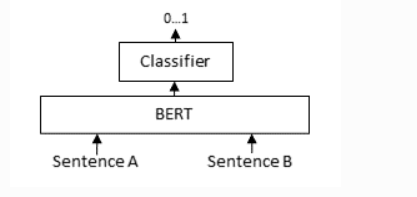

These output probabilities are then ranked to get the top hits

Since the more expensive second step (ranking) is performed for only 100s of documents retrieved by the retrieval step as opposed to the millions before retrieval , it is much faster

## References

1) https://arxiv.org/abs/1908.10084
2) https://www.sbert.net/